<a href="https://colab.research.google.com/github/mateopolancecofficial/DeepLearningProjects/blob/main/ComputerVision/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 9.8MB/s 


In [2]:
# set installation txt file with all relevant packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import shutil
import random
import imghdr

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kerastuner as kt

In [3]:
#tf.debugging.set_log_device_placement(True)

if tf.config.list_physical_devices('GPU'):
  if len(tf.config.list_physical_devices('GPU')) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
  else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    strategy = None

Num GPUs Available:  1


In [4]:
# download images folder
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
from shutil import unpack_archive
unpack_archive('/content/flower_photos.tgz', '/content/')

--2021-06-14 21:37:56--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   193MB/s    in 1.1s    

2021-06-14 21:37:58 (193 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [5]:
# load data parameters

MAX_WIDTH, MAX_HEIGHT = 100, 100
ORIGIN = os.path.dirname(os.path.abspath("ImageClassification.ipynb"))
print(ORIGIN)
SOURCE = 'flower_photos'
#test_path = ''
# available color modes are "grayscale", "rgb", "rgba", 
# (images will be converted to have 1, 3, or 4 channels)
COLOR_MODE = "rgb"
SOURCE_PATH = os.path.join(ORIGIN, SOURCE)
#test_source_folder_path = os.path.join(ORIGIN, test_path)
print(SOURCE_PATH)

BATCH_SIZE = 32
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2
SEED = 100

IMAGE_EXTENSIONS = ['png', 'jpg', 'jpeg', 'tiff', 'bmp', 'gif']


/content
/content/flower_photos


In [6]:
# split dataset on test and train if is not currently

def train_test_split():
  """
  Create train and test subsets from source dataset.
  """

  source_path = os.path.join(ORIGIN, SOURCE_PATH)
  train_path = "train_data"
  test_path = "test_data"
  train_path = os.path.join(ORIGIN, train_path)
  test_path = os.path.join(ORIGIN, test_path)

  if os.path.exists(train_path):
    shutil.rmtree(train_path)
  os.mkdir(train_path)

  if os.path.exists(test_path):
    shutil.rmtree(test_path)
  os.mkdir(test_path)

  num_of_classes = len(os.listdir(source_path))

  for dir in os.listdir(source_path):
    files = os.listdir(os.path.join(source_path, dir))
    if len(files) > 0:
      # create train dataset dir
      if not os.path.exists(os.path.join(train_path, dir)):
        os.mkdir(os.path.join(train_path, dir))
      # create test dataset dir
      if not os.path.exists(os.path.join(test_path, dir)):
        os.mkdir(os.path.join(test_path, dir))
      # extract names of test subset files
      test_num = len(files) * TEST_SPLIT
      indicies = random.sample(range(len(files)), round(test_num))
      test_files_names = [files[i] for i in indicies]
      
      for f in files:
        if f in test_files_names:
          # move file from source dataset to test dataset
          image_type = imghdr.what(os.path.join(os.path.join(source_path, dir), f))
          if image_type in IMAGE_EXTENSIONS:
            os.replace(os.path.join(os.path.join(source_path, dir), f), 
                       os.path.join(os.path.join(test_path, dir), f))
        
        else:
          # move file from source dataset to test dataset
          image_type = imghdr.what(os.path.join(os.path.join(source_path, dir), f))
          if image_type in IMAGE_EXTENSIONS:
            os.replace(os.path.join(os.path.join(source_path, dir), f), 
                       os.path.join(os.path.join(train_path, dir), f))
      
      

  return train_path, test_path, num_of_classes


In [7]:
def get_min_img_size(train_path, test_path=None):
  """
  Check if all images are of the same size and get min image width and min image
  height.
  param train_path:              path of a train source folder
  param test_path:               path of a test source folder
  return img_width, img_height:  min image width and height scalar values
  """

  img_width_list = []
  img_height_list = []

  def get_image_params(data_path):
    img_width, img_height = None, None
    dirs = os.listdir(data_path)
    for dir in dirs:
      files = os.listdir(data_path + "/" + dir)
      for f in files:
        image_path = data_path + "/" + dir + "/" + f
        image = tf.keras.preprocessing.image.load_img(image_path)
        image = keras.preprocessing.image.img_to_array(image)
        if img_width == None:
          img_width, img_height = image.shape[0], image.shape[1]
        else:
          if image.shape[0] < img_width:
            img_width = image.shape[0]
          if image.shape[1] < img_height:
            img_height = image.shape[1]

    return img_width, img_height

  if test_path == None:
    return get_image_params(train_path)
    
  else:
    img_width_train, img_height_train = get_image_params(train_path)
    img_width_list.append(img_width_train)
    img_height_list.append(img_height_train)

    img_width_test, img_height_test = get_image_params(test_path)
    img_width_list.append(img_width_test)
    img_height_list.append(img_height_test)
  
    return min(img_width_list), min(img_height_list)

In [8]:
def set_resize_image_parameters(img_width, img_height):
  """
  Set parameters for resizing input images.
  param img_width, img_height:   image height and image with scalar values
  return img_width, img_height:  resized image height and image with scalar values     
  """

  if img_width > MAX_WIDTH:
    img_width = MAX_WIDTH

  if img_height > MAX_HEIGHT:
    img_height = MAX_HEIGHT
  
  return img_height, img_width



In [9]:
# set tensorflow dataset parameters
# remove unneccessary files from source directory
train_path, test_path, num_of_classes = train_test_split()
img_width, img_height = get_min_img_size(train_path, test_path=test_path)
img_width, img_height = set_resize_image_parameters(img_height, img_width)
image_size = (img_width, img_height)
print(image_size)

(100, 100)


In [10]:
def get_image_dataset(data_path, image_size, num_of_classes, subset = None):
  """
  Create tensorflow dataset from data directory object.
  param data_path:        string, source folder path
  param image_size:       touple (image_with, image_height)
  param subset:           optional, name of subset ('train', 'validation')
  return dataset:         dict, tensorflow dataset and class names
  """
    
  if subset:
    validation_split = VALIDATION_SPLIT
    seed = SEED
  
  else:
    validation_split = None
    seed = None

  dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      color_mode=COLOR_MODE,
      image_size=image_size,
      batch_size=BATCH_SIZE,
      seed=seed,
      validation_split=validation_split, 
      subset=subset
    )
    
  dataset.class_names.sort()
  class_names = dataset.class_names
    
  return {
      "data": dataset,
      "classNames": class_names
        }

In [11]:

training_ds = get_image_dataset(
    train_path,
    image_size,
    num_of_classes,
    subset = "training"
)

validation_ds = get_image_dataset(
    train_path,
    image_size,
    num_of_classes,
    subset = "validation"
)


test_ds = get_image_dataset(
    test_path,
    image_size,
    num_of_classes
)


Found 2935 files belonging to 5 classes.
Using 2348 files for training.
Found 2935 files belonging to 5 classes.
Using 587 files for validation.
Found 735 files belonging to 5 classes.


In [12]:
def check_data(training_ds, validation_ds, test_ds):

  # check does training and validation datasets contains same classes
  validation_check = training_ds["classNames"] == validation_ds["classNames"]
  assert_fail_message = "Training and Validation classes should match. "
  assert(validation_check), assert_fail_message

  # check does training and test datasets contains same classes
  test_check = training_ds["classNames"] == test_ds["classNames"]
  assert_fail_message = "Training and Test classes should match. "
  assert(test_check), assert_fail_message

  class_names = training_ds["classNames"]
  number_classes = len(class_names)
  print(training_ds["classNames"])
  print(validation_ds["classNames"])
  print(test_ds["classNames"])

  return class_names

In [13]:
class_names = check_data(training_ds, validation_ds, test_ds)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [14]:
def visualize_dataset(dataset):
  """
  Visualize input images.
  param dataset: tensorflow dataset objects
  """

  image_shape = []
  plt.figure(figsize=(10, 10))
  
  # take first batch (batch_size = num_of_images = num_of_labels)
  # labels are label encoded
  # images are unscaled (0 - 255) 4D tensors (batch_size, width, height, chanells)
  for images, labels in dataset.take(1):
    # take first 9 images and labels from first batch
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  
  for image_batch, labels_batch in dataset.take(1):
    image_shape = [image_batch.shape[1], image_batch.shape[1], 
                   image_batch.shape[2], image_batch.shape[3]]
    print("Image batch shape is {}".format(image_batch.shape))
    print("Label batch shape is {}".format(labels_batch.shape))
    break
  
  return image_shape

Image batch shape is (32, 100, 100, 3)
Label batch shape is (32,)


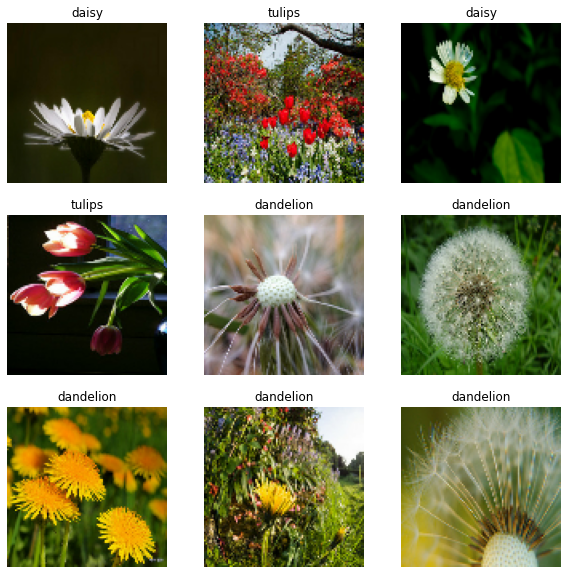

In [15]:
image_shape = visualize_dataset(training_ds['data'])

In [20]:
def data_augmentation(dataset):
  """
  Rescale input dataset in range [0, 1].
  param dataset: tensorflow dataset
  return normalized_dataset: normalized input dataset
  """

  def label_preprocess(image, label):
    label = tf.one_hot(label, num_of_classes)
    return image, label

  normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
  dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

  random_flip_layer = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
  dataset = dataset.map(lambda x, y: (random_flip_layer(x), y))

  random_rotation_layer = layers.experimental.preprocessing.RandomRotation(0.3)
  dataset = dataset.map(lambda x, y: (random_rotation_layer(x), y))

  dataset = dataset.map(label_preprocess)

  return dataset

In [32]:

AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#train_dataset = training_ds['data'].map(input_preprocess)
train_dataset = data_augmentation(training_ds['data'])
#train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#train_dataset = train_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)

#val_dataset = validation_ds['data'].map(input_preprocess)
val_dataset = data_augmentation(validation_ds['data'])
#val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#val_dataset = val_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)

#test_dataset = test_ds['data'].map(input_preprocess)
test_dataset = data_augmentation(test_ds['data'])
#test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)


In [33]:
def create_model(hp):
  """
  Create and compile model. Use keras functional API.
  param image_shape: list of one image input shape parameters
  """

  # define hyper-parameters for tuning
  hp_units = hp.Int('hp_units', min_value=128, max_value=256, step=32)

  inputs = keras.Input(shape=(image_shape[2], image_shape[1], image_shape[3]), 
                      name="input_img")
    
  x = layers.Conv2D(32, 3, activation="relu")(inputs)
  x = layers.Conv2D(64, 3, activation="relu")(x)
  block_1_output = layers.MaxPooling2D()(x)

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_2_output = layers.add([x, block_1_output])
  normalized_1 = layers.BatchNormalization()(block_2_output)

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(normalized_1)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_3_output = layers.add([x, normalized_1])
  normalized_2 = layers.BatchNormalization()(block_3_output)

  x = layers.Conv2D(128, 3, activation="relu")(normalized_2)
  x = layers.MaxPooling2D()(x)

  x = layers.Flatten()(x)

  x = layers.Dense(units=hp_units, activation="relu")(x)
  x = layers.Dropout(rate=hp.Float(
                    'dropout_1',
                    min_value=0.1,
                    max_value=0.5,
                    default=0.25,
                    step=0.1,
                    ))(x)

  outputs = layers.Dense(num_of_classes, activation='softmax',
                         kernel_regularizer=tf.keras.regularizers.L2(1e-4),
                         bias_regularizer=tf.keras.regularizers.L2(1e-4))(x)

  model = keras.Model(inputs, outputs, name="image_classifier")

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[auc_score])

  return model

In [34]:
def set_hyperparameter_optimizer(strategy):
  """
  Set hyperparameter optimizer.
  """
  #objective=kt.Objective("auc_score", direction="min"),
  tuner = kt.Hyperband(
        hypermodel=create_model,
        objective=kt.Objective("val_auc_score", direction="min"),
        max_epochs=8,
        factor=2,
        hyperband_iterations=3,
        distribution_strategy=strategy,
        directory='results_dir',
        project_name='image_classification')

  return tuner


In [35]:
num_of_classes = len(class_names)
auc_score = tf.keras.metrics.AUC(from_logits=False, multi_label=True,
              num_labels=num_of_classes, name='auc_score')
tuner = set_hyperparameter_optimizer(strategy)

INFO:tensorflow:Reloading Oracle from existing project results_dir/image_classification/oracle.json


In [36]:
print(num_of_classes)

5


In [37]:
# define early stop callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc_score', patience=10)

In [ ]:
tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=5,
             callbacks=[stop_early])

# get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 24 Complete [00h 00m 21s]
val_auc_score: 0.4944639205932617

Best val_auc_score So Far: 0.44557562470436096
Total elapsed time: 00h 07m 17s

Search: Running Trial #25

Hyperparameter    |Value             |Best Value So Far 
hp_units          |160               |160               
dropout_1         |0.5               |0.1               
learning_rate     |0.01              |0.01              
tuner/epochs      |4                 |2                 
tuner/initial_e...|2                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |1                 |0                 
tuner/trial_id    |dc90bf766b0b484...|None              

Epoch 3/4
74/74 [==============================] - 10s 114ms/step - loss: 69.0990 - auc_score: 0.4999 - val_loss: 1.6037 - val_auc_score: 0.5000
Epoch 4/4
30/74 [===========>..................] - ETA: 4s - loss: 1.6036 - auc_score: 0.4803

In [39]:
train_dataset

<MapDataset shapes: ((None, 100, 100, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [40]:
val_dataset

<MapDataset shapes: ((None, 100, 100, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [ ]:
model = tuner.hypermodel.build(best_hps)

<MapDataset shapes: ((None, 100, 100, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [ ]:
# checkpoints callback is not defined because a lack of disk space on Google Colab
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=[stop_early]
                    )